# 0.0 Introduction
This code attempts to solve the challenge hosted on DrivenData.org The challenge can be accessed via https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table

A walk-through of this code is available at: https://medium.com/@antoniostark/a4d2c428a2eb

This is the second of two parts that attempts to solve the challenge. The first part can be found at the following links below:

Github: https://github.com/AntonioStark/Taarifa-Water-Pumps/blob/master/Taarifa%20Water%20Pumps%20pt.1%20Data%20Preprocessing%20EDA.ipynb

Medium: https://medium.com/@antoniostark/50ba6ea65c0a

# 1.0 Problem Description
The challenge is to create a model that will predict the condition of a particular water pump ("waterpoint") given its many attributes.

In [1]:
# general package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2.0 Data preparation
We've finally managed to get our data preprocessed! Now we're going to run it through some models and see if it gives us any significant results. Let's import our preprocessed dataset from the working directory.


In [2]:
# import data
df = pd.read_csv('preprocessed_dataset.csv')
## because we're importing from a .csv file, we have one column that's just the row number
df.drop(columns=['Unnamed: 0'],inplace=True)

print('df is a dataset of %d data points of %d features'%(df.shape[0],df.shape[1]))

df is a dataset of 74250 data points of 114 features


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option('display.max_columns',6)

In [4]:
df.head()

,gps_height,longitude,latitude,...,source_class_groundwater,source_class_surface,source_class_unknown
0,1390,34.938093,-9.856322,...,1,0,0
1,1399,34.698766,-2.147466,...,0,1,0
2,686,37.460664,-3.821329,...,0,1,0
3,263,38.486161,-11.155298,...,1,0,0
4,0,31.130847,-1.825359,...,0,1,0


In [5]:
## there seems to be a small error in there being both numerics and strings of those numerics in the status_group. Let's quickly fix that
status_group_dict = {'2':2,'1':1,'0':0}
df.status_group = df.status_group.replace(status_group_dict)

## 2.1 Data Splitting
Currently our test dataset has no labels associated with them. To gauge whether or not our model is working well, we need to artificially create testing datasets from our training dataset.
Let's take a one-third random sample from our training dataset and designate that as our testing set for our models.

In [6]:
from sklearn.model_selection import train_test_split

train = df[df.train==True].drop(columns=['train'])
X = train.drop(columns=['status_group'])
y = train.status_group

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)

## numpy in the models below did not seem to recognize the dtype of the y's as 'int.' So we're explicitly calling them out here.
y_train = pd.Series(np.asarray(y_train,dtype='int'))
y_test = pd.Series(np.asarray(y_test,dtype='int'))

dfs = (X_train,X_test,y_train,y_test)
df_names = ('X_train','X_test','y_train','y_test')
for i in range(len(dfs)):
    print('%s shape: %s'%(df_names[i],dfs[i].shape))

X_train shape: (39798, 112)
X_test shape: (19602, 112)
y_train shape: (39798,)
y_test shape: (19602,)


## 2.2 Data output imbalance
Let's quickly re-check our label balances here.

In [7]:
def df_imbalance(df):
    labels = df.unique()
    print('there are %d labels: \n'%len(labels))
    labels_count = df.value_counts()
    print(labels_count)
    labels_percentage = labels_count/np.sum(labels_count)*100
    print('\neach with %.1f%%, %.1f%%, %.1f%%'%(labels_percentage[0],labels_percentage[1],labels_percentage[2]))

print('outputs of y_train:')
df_imbalance(y_train)
print('\noutputs of y_test:')
df_imbalance(y_test)

outputs of y_train:
there are 3 labels: 

2    21629
0    15252
1     2917
dtype: int64

each with 38.3%, 7.3%, 54.3%

outputs of y_test:
there are 3 labels: 

2    10630
0     7572
1     1400
dtype: int64

each with 38.6%, 7.1%, 54.2%


It seems like our random splitting did pretty well! Our output balance is pretty identical to both our training and testing dataset. The output classes are a bit imbalanced, we'll get to that later

# 3.0 Modeling
While there are many types of classifiers we can use, they are generally put into these three families: nearest neighbors, decision trees, and support vector machines. We're going to look at one example model from each family of models.

Do note that our task is a multi-class classification problem. While there are ways to do multi-class logistic regression, we're not doing it here.

There's also a lot of relationships between our features. This is either because they correspond to similar aspects (e.g. latitude and longitude), or are results of one-hot encoding. That's why we won't be doing a Naive Bayes model here as well.

The metric employed by Taarifa is the "classification rate" - the percentage of correct classification by the model. Let's look at the classification rate and run time of each model.

In [8]:
# packages required for metrics
import time, math
from sklearn.metrics import accuracy_score

cols_results=['family','model','classification_rate','runtime']
results = pd.DataFrame(columns=cols_results)

results

,family,model,classification_rate,runtime


## 3.1 K-Nearest Neighbors (KNNs)
We'll use KNN as a representative Nearest-Neighbor model.

A KNN is a "lazy classifier" - it does not build any internal models, but simply "stores" all the instances in the training dataset.

Therefore, a KNN has no "training time" - instead, it takes a lot of time in prediction. It is especially awful when we have a large dataset and the KNN has to evaluate the distance between the new datapoint and existing datapoints.

Let's see how a KNN does in accuracy and time for k = 1 to 9

In [9]:
from sklearn.neighbors import KNeighborsClassifier

kVals = range(1,10)
knn_names = ['KNN-'+str(k) for k in kVals]

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    time_start = time.time()
    y_pred = knn.predict(X_test)
    time_run = time.time()-time_start
    
    results = results.append(pd.DataFrame([['KNN',knn_names[k-1],accuracy_score(y_test,y_pred),time_run]],columns=cols_results),ignore_index=True)

results[results.family=='KNN']

,family,model,classification_rate,runtime
0,KNN,KNN-1,0.650954,3.882647
1,KNN,KNN-2,0.608611,4.331218
2,KNN,KNN-3,0.665544,4.663277
3,KNN,KNN-4,0.652740,4.692356
4,KNN,KNN-5,0.671768,4.821031
5,KNN,KNN-6,0.666310,5.039141
6,KNN,KNN-7,0.671360,5.232532
7,KNN,KNN-8,0.670442,5.244241
8,KNN,KNN-9,0.673350,5.388956


Okay, so we have our KNNs here. Let's visualize how well they've done and how much time they've took

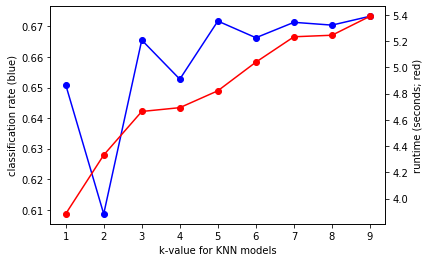

In [10]:
fig, ax = plt.subplots()
ax.plot(kVals,results[results.family=='KNN'].classification_rate,color='blue',marker='o')
ax.set_xlabel('k-value for KNN models')
ax.set_ylabel('classification rate (blue)')
ax2=ax.twinx()
ax2.plot(kVals,results[results.family=='KNN'].runtime,color='red',marker='o')
ax2.set_ylabel('runtime (seconds; red)')
plt.show()

The accuracy does fluctuate a bit at first, but gradually stabilizes around 67% as we take more neighbors into account. The runtime generally increases linearly with k-value.

## 3.2 Random Forest
For our Decision-Tree based model, we'll create a random forest. Random forest is a method of creating multiple decision trees over a subset of the training dataset and taking the consensus result. Because of this random subsetting method, random forests are resillient to overfitting, but takes longer time to train than a single decision tree.

Let's see how random forests of 1 (this is just a single decision tree), 10, 100, and 1,000 trees fare.

In [11]:
from sklearn.ensemble import RandomForestClassifier
rVals = range(1,4)
rf_names = ['RF-'+str(int(math.pow(10,r))) for r in rVals]

for r in rVals:
    clf = RandomForestClassifier(n_estimators=int(math.pow(10,r)),random_state=0)
    time_start = time.time()
    clf.fit(X_train,y_train)
    time_run = time.time()-time_start
    y_pred=clf.predict(X_test)
    
    results = results.append(pd.DataFrame([['RF',rf_names[r-1],accuracy_score(y_test,y_pred),time_run]],columns=cols_results),ignore_index=True)
    
results[results.family=='RF']

,family,model,classification_rate,runtime
9,RF,RF-10,0.781094,0.617978
10,RF,RF-100,0.796959,5.720452
11,RF,RF-1000,0.799051,58.886793


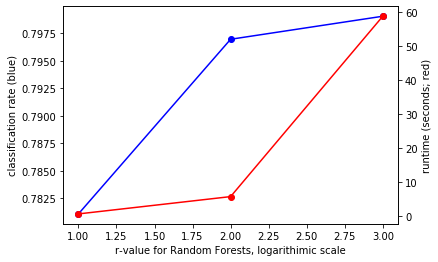

In [12]:
fig, ax = plt.subplots()
ax.plot(rVals,results[results.family=='RF'].classification_rate,color='blue',marker='o')
ax.set_xlabel('r-value for Random Forests, logarithimic scale')
ax.set_ylabel('classification rate (blue)')
ax2=ax.twinx()
ax2.plot(rVals,results[results.family=='RF'].runtime,color='red',marker='o')
ax2.set_ylabel('runtime (seconds; red)')
plt.show()

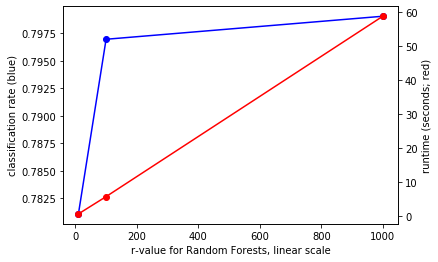

In [13]:
fig, ax = plt.subplots()
ax.plot([math.pow(10,r) for r in rVals],results[results.family=='RF'].classification_rate,color='blue',marker='o')
ax.set_xlabel('r-value for Random Forests, linear scale')
ax.set_ylabel('classification rate (blue)')
ax2=ax.twinx()
ax2.plot([math.pow(10,r) for r in rVals],results[results.family=='RF'].runtime,color='red',marker='o')
ax2.set_ylabel('runtime (seconds; red)')
plt.show()

The runtime increases almost exactly linearly with the number of decision trees in the random forest, as to be expected. The accuracy, however, does not increase much, and is in the 80% ballpark.

## 3.3 SVM
SVMs utilize what's known as a "kernel trick" to create hyperplane separators for your data (i.e. linear separators for non-linear problems). While SVMs "could" overfit in theory, the generalizability of kernels usually makes it resistant from small overfitting.

SVMs do tend to take a lot of time, and its success is highly dependent on its kernel. A pure SVM on this dataset (40k data points of 100 features) will take forever to run, so we'll create a "bagged classifier" using the BaggingClassifier library offered by sklearn. The BaggingClassifier will take a base model (for us, the SVM), and train multiple of it on multiple random subsets of the dataset. For us, let's train 10 SVM models per kernel on 1% of the data (about 400 data points) each time.

Let's see how well different kernels work on our dataset.

In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
kernels = ['linear','rbf','sigmoid']
kernel_names = ['SVM-'+kernel for kernel in kernels]

for i in range(len(kernels)):
    clf = SVC(kernel=kernels[i],random_state=0)
    time_start = time.time()
    clf = BaggingClassifier(base_estimator=clf,n_estimators=10,max_samples=0.01,n_jobs=-1,random_state=0)
    clf.fit(X_train,y_train)
    time_run = time.time()-time_start
    y_pred=clf.predict(X_test)
    
    results = results.append(pd.DataFrame([['SVM',kernel_names[i],accuracy_score(y_test,y_pred),time_run]],columns=cols_results),ignore_index=True)
    
results[results.family=='SVM']

,family,model,classification_rate,runtime
12,SVM,SVM-linear,0.704316,157.753642
13,SVM,SVM-rbf,0.534027,0.335257
14,SVM,SVM-sigmoid,0.542037,0.325962


Text(0, 0.5, 'classification rate (blue)')

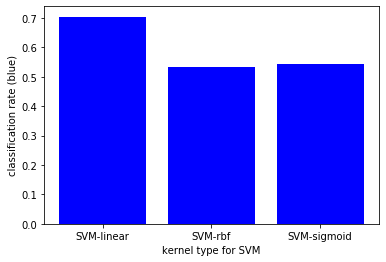

In [15]:
plt.bar(x=results[results.family=='SVM'].model,height=results[results.family=='SVM'].classification_rate,color='blue')
plt.xlabel('kernel type for SVM')
plt.ylabel('classification rate (blue)')

Text(0, 0.5, 'runtime (seconds; red)')

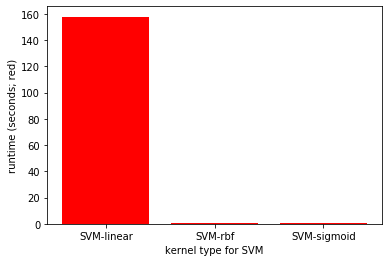

In [16]:
plt.bar(x=results[results.family=='SVM'].model,height=results[results.family=='SVM'].runtime,color='red')
plt.xlabel('kernel type for SVM')
plt.ylabel('runtime (seconds; red)')

The linear kernel does show the highest accuracy, but it has a horrible training time. Considering that we took a bagging approach that will take at maximum 10% of the data (=10 SVMs of 1% of the dataset each), the accuracy is actually pretty impressive.

# 4.0 Results
Let's compare the accuracy results from all the models!

In [17]:
results

,family,model,classification_rate,runtime
0,KNN,KNN-1,0.650954,3.882647
1,KNN,KNN-2,0.608611,4.331218
2,KNN,KNN-3,0.665544,4.663277
3,KNN,KNN-4,0.652740,4.692356
4,KNN,KNN-5,0.671768,4.821031
5,KNN,KNN-6,0.666310,5.039141
6,KNN,KNN-7,0.671360,5.232532
7,KNN,KNN-8,0.670442,5.244241
8,KNN,KNN-9,0.673350,5.388956
9,RF,RF-10,0.781094,0.617978


Text(0, 0.5, 'model type')

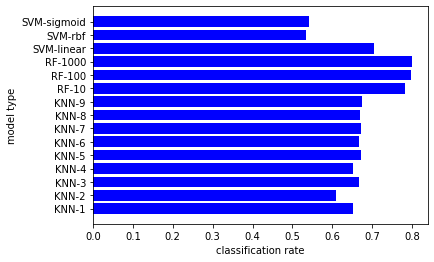

In [18]:
plt.barh(results.model,results.classification_rate,color='blue')
plt.xlabel('classification rate')
plt.ylabel('model type')

Text(0, 0.5, 'model type')

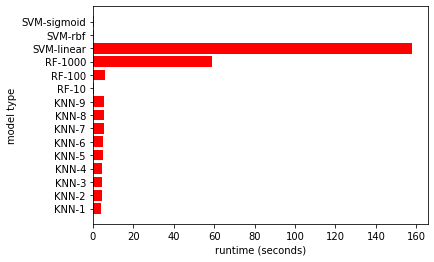

In [19]:
plt.barh(results.model,results.runtime,color='red')
plt.xlabel('runtime (seconds)')
plt.ylabel('model type')

## 4.1 Base Case: Random Classifier
How can we gauge how good the model works? One way to do this is to create a random classifier that will classify the input randomly and compare the results. The random assignment of labels will follow the "base" proportion of the labels given to it at training.

In [20]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='stratified',random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy of a random classifier is: %.2f%%'%(accuracy_score(y_test,y_pred)*100))

Accuracy of a random classifier is: 44.92%


It seems like for a base accuracy of 45%, all of our models have done pretty well in terms of accuracy.

## 4.2 Class Imbalance - Undersampling
Lastly, we come back to the class imbalance problem that we've mentioned at the beginning. The imbalance in labels leads classifers to bias towards the majority label. For our case, it's towards the 'functional' label.

We've already seen that a classifier that predicts the 'functional' label for half the time ('functional' label takes up 54.3% of the dataset) will already achieve 45% accuracy. This is already far better than a uniform random guess of 33% (1/3).

Class imbalance may not affect classifiers if the classes are clearly separate from each other, but in most cases they aren't. To see whether or not class imbalance affected our models, we can undersample the data.

Balanced undersampling means that we take a random sample of our data where the classes are 'balanced.' This can be done using the imblearn library's RandomUnderSampler class. Think of imblearn as an sklearn library for imbalanced datasets.

In [26]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_rus_train,y_rus_train = rus.fit_resample(X_train,y_train)
X_rus_test,y_rus_test = rus.fit_resample(X_test,y_test)

print('X_rus_train is a dataset of %d data points of %d features'%(X_rus_train.shape[0],X_rus_train.shape[1]))
print('X_rus_test is a dataset of %d data points of %d features'%(X_rus_test.shape[0],X_rus_test.shape[1]))

X_rus_train is a dataset of 8751 data points of 112 features
X_rus_test is a dataset of 4200 data points of 112 features


While our original X_train had almost 40,000 datapoints, our undersampled dataset only has about 8,700 datapoints. Let's run it through our most successful model - random forests - and see if undersampling affects our model accuracy.

In [35]:
rf_rus_names = ['RF_rus-'+str(int(math.pow(10,r))) for r in rVals]

for r in rVals:
    clf = RandomForestClassifier(n_estimators=int(math.pow(10,r)),random_state=0)
    time_start = time.time()
    clf.fit(X_rus_train,y_rus_train)
    time_run = time.time()-time_start
    y_rus_pred=clf.predict(X_rus_test)
    
    results = results.append(pd.DataFrame([['RF',rf_rus_names[r-1],accuracy_score(y_rus_test,y_rus_pred),time_run]],columns=cols_results),ignore_index=True)
    
results[results.family=='RF']

,family,model,classification_rate,runtime
9,RF,RF-10,0.781094,0.617978
10,RF,RF-100,0.796959,5.720452
11,RF,RF-1000,0.799051,58.886793
15,RF,RF_rus-10,0.684524,0.114116
16,RF,RF_rus-100,0.697143,0.885368
17,RF,RF_rus-1000,0.700714,9.037169


So our model accuracy has decreased from close to 80% to under 70%. A part of this is from the fact that the model has had a reduced dataset to work with. But another factor is that our original Random Forest models were getting a falsely "inflated" accuracy due to the majority class bias, which is now gone after classes have been imbalanced. At the same time, balancing of the class does lead to an objectively more accurate model, albeit not a more effective one. The ultimate decision is yours to make  - would you care about "inflated" accuracy, or would these "false positives" deter you from using the original models?

As our "false positives" may lead us to declare non-functional or in-need-of-repair waterpoints to go unaddressed, we might want to err the other way, but the choice is up to you.